In [119]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

DATA_PATH = "../data"
COMMITTEE_MEETINGS_PATH = f"{DATA_PATH}/committees/meetings/2019-2022/downloaded/"
COMMITTEE_MEETINGS_FILES = [
    "house_energy_and_commerce.csv",
    "house_financial_services.csv",
    "senate_banking.csv",
    "senate_help.csv",
]

STOCK_DATA_PATH = f"{DATA_PATH}/cleaned/2014-2023/"
STOCK_YEARS = [2019, 2020, 2021, 2022]


In [120]:

df_1 = pd.read_csv(f"{COMMITTEE_MEETINGS_PATH}{COMMITTEE_MEETINGS_FILES[0]}")
df_2 = pd.read_csv(f"{COMMITTEE_MEETINGS_PATH}{COMMITTEE_MEETINGS_FILES[1]}")
df_3 = pd.read_csv(f"{COMMITTEE_MEETINGS_PATH}{COMMITTEE_MEETINGS_FILES[2]}")
df_4 = pd.read_csv(f"{COMMITTEE_MEETINGS_PATH}{COMMITTEE_MEETINGS_FILES[3]}")

# date in this format 2022-12-13T15:00:00Z
df = pd.concat([df_1, df_2, df_3, df_4])
df["meeting_date"] = pd.to_datetime(df["Meeting Date"]).dt.strftime("%Y-%m-%d")

print("rows", len(df))
df.head()


rows 1180


,Meeting Title,URL,Congress,Chamber,Meeting Date,Committee,meeting_date
0,H. Res. 1476,https://www.congress.gov/event/117th-congress/...,117th,House of Representatives,2022-12-14T15:30:00Z,House Energy and Commerce,2022-12-14
1,24 bills,https://www.congress.gov/event/117th-congress/...,117th,House of Representatives,2022-09-21T14:15:00Z,House Energy and Commerce,2022-09-21
2,Five Health Bills,https://www.congress.gov/event/117th-congress/...,117th,House of Representatives,2022-09-14T14:30:00Z,House Energy and Commerce,2022-09-14
3,Six Bills,https://www.congress.gov/event/117th-congress/...,117th,House of Representatives,2022-07-20T13:45:00Z,House Energy and Commerce,2022-07-20
4,“Roe Reversal: The Impacts of Taking Away the ...,https://www.congress.gov/event/117th-congress/...,117th,House of Representatives,2022-07-19T14:30:00Z,House Energy and Commerce,2022-07-19


In [132]:
stock_tx = pd.read_csv(f"{STOCK_DATA_PATH}/stocks.csv")
print(stock_tx["type"].unique())
stock_tx.head()

['purchase' 'sale_partial' 'sale_full' 'exchange' 'sale' 'Sale (Full)'
 'Sale (Partial)' 'Purchase' 'Exchange']


,transaction_date,ticker,asset_description,type,amount,state,ptr_link,industry,sector,party,chamber,member,year,last_name,member_id
0,2021-09-27,BP,BP plc,purchase,8000,NC,https://disclosures-clerk.house.gov/public_dis...,Integrated oil Companies,Energy,R,House,Virginia Foxx,2021,foxx,F000450
1,2021-09-13,XOM,Exxon Mobil Corporation,purchase,8000,NC,https://disclosures-clerk.house.gov/public_dis...,Integrated oil Companies,Energy,R,House,Virginia Foxx,2021,foxx,F000450
2,2021-09-10,ILPT,Industrial Logistics Properties Trust - Common...,purchase,35000,NC,https://disclosures-clerk.house.gov/public_dis...,Real Estate Investment Trusts,Real Estate,R,House,Virginia Foxx,2021,foxx,F000450
3,2021-09-28,PM,Phillip Morris International Inc,purchase,35000,NC,https://disclosures-clerk.house.gov/public_dis...,Farming/Seeds/Milling,Consumer Non-Durables,R,House,Virginia Foxx,2021,foxx,F000450
4,2021-09-17,BLK,BlackRock Inc,sale_partial,8000,CA,https://disclosures-clerk.house.gov/public_dis...,Investment Bankers/Brokers/Service,Finance,D,House,Alan S. Lowenthal,2021,lowenthal,L000579


In [122]:
df['meeting_date'] = pd.to_datetime(df['meeting_date'])
stock_tx['transaction_date'] = pd.to_datetime(stock_tx['transaction_date'])
G = nx.Graph()

for idx, row in df.iterrows():
    node_id = f"meeting_{idx}"
    G.add_node(node_id, type="meeting", title=row['Meeting Title'], date=row['meeting_date'])

for idx, row in stock_tx.iterrows():
    node_id = f"tx_{idx}"
    G.add_node(node_id, type="transaction", member=row['member'], date=row['transaction_date'])

for m_idx, m_row in df.iterrows():
    meeting_node = f"meeting_{m_idx}"
    meeting_date = m_row['meeting_date']
    window_start = meeting_date - pd.Timedelta(days=30)
    window_end = meeting_date + pd.Timedelta(days=30)
    
    matching_txs = stock_tx[
        (stock_tx['transaction_date'] >= window_start) &
        (stock_tx['transaction_date'] <= window_end)
    ]
    
    for tx_idx in matching_txs.index:
        transaction_node = f"tx_{tx_idx}"
        G.add_edge(meeting_node, transaction_node)

# Step 6: Inspect the graph
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

print("\nSample edges (meeting_node, transaction_node):")
for i, (u, v) in enumerate(G.edges()):
    if i >= 10:
        break
    print(u, v)

Total nodes: 22391
Total edges: 639581

Sample edges (meeting_node, transaction_node):
meeting_0 tx_270
meeting_0 tx_271
meeting_0 tx_568
meeting_0 tx_569
meeting_0 tx_570
meeting_0 tx_571
meeting_0 tx_572
meeting_0 tx_719
meeting_0 tx_720
meeting_0 tx_721


In [123]:
# Separate nodes by their type attribute
meeting_nodes = [n for n, d in G.nodes(data=True) if d.get("type") == "meeting"]
tx_nodes      = [n for n, d in G.nodes(data=True) if d.get("type") == "transaction"]

# Compute a layout for all nodes (spring layout tends to work well for bipartite‐like graphs)
# pos = nx.spring_layout(G, seed=42)

# plt.figure(figsize=(12, 12))

# # Draw meeting nodes as red squares
# nx.draw_networkx_nodes(
#     G,
#     pos,
#     nodelist=meeting_nodes,
#     node_color="red",
#     node_shape="s",
#     node_size=300,
#     label="Meeting"
# )

# # Draw transaction nodes as blue circles
# nx.draw_networkx_nodes(
#     G,
#     pos,
#     nodelist=tx_nodes,
#     node_color="blue",
#     node_shape="o",
#     node_size=100,
#     label="Transaction"
# )

# # Draw edges between meetings and transactions
# nx.draw_networkx_edges(G, pos, alpha=0.5)

# # Optionally, add labels (using meeting titles and member names)
# labels = {}
# for n, data in G.nodes(data=True):
#     if data.get("type") == "meeting":
#         labels[n] = data.get("title")
#     else:
#         labels[n] = data.get("member")

# nx.draw_networkx_labels(G, pos, labels, font_size=8)

# # Add a legend and turn off axes
# plt.legend(scatterpoints=1)
# plt.axis("off")
# plt.title("Meeting–Transaction Network (±7 days)")
# plt.show()

In [124]:
import networkx as nx

# ─── Assume G is your already‐built Graph ──────────────────────────────────

# 1) Extract only the meeting‐nodes
meeting_nodes = [n for n,d in G.nodes(data=True) if d["type"] == "meeting"]

# 2) Compute degree (i.e. # of adjacent transactions) for each meeting
meeting_degrees = dict(G.degree(meeting_nodes))

# 3) Sort meetings by degree, descending
sorted_meetings = sorted(meeting_degrees.items(), key=lambda x: x[1], reverse=True)


print("Top 10 meetings by # of nearby transactions:")
for node_id, deg in sorted_meetings[:10]:
    title = G.nodes[node_id]["title"]
    date = G.nodes[node_id]["date"]
    print(f"  • {title:30s} | {deg} transactions | {date} ")


Top 10 meetings by # of nearby transactions:
  • S.Hrg. 116-318 — NOMINATIONS OF BRIAN D. MILLER AND DANA WADE | 4163 transactions | 2020-05-05 00:00:00 
  • Hearings to examine the nominations of Brian D. Miller, of Virginia, to be Special Inspector General for Pandemic Recovery, Department of the Treasury, and Dana T. Wade, of the District of Columbia, to be an Assistant Secretary of Housing and Urban Development. | 4094 transactions | 2020-05-05 00:00:00 
  • An oversight hearing to examine financial regulators. | 3842 transactions | 2020-11-10 00:00:00 
  • S.Hrg. 117-169 — NOMINATION OF MIGUEL CARDONA TO SERVE AS SECRETARY OF EDUCATION | 3762 transactions | 2021-02-03 00:00:00 
  • An oversight hearing to examine the Securities and Exchange Commission, including S.2075, to amend the Securities Exchange Act of 1934 to require issuers to disclose certain activities relating to climate change, S.2391, to amend the Securities Exchange Act of 1934 to impose requirements relating to the

In [125]:
import pandas as pd
import networkx as nx
from collections import Counter

# ─── Assume stock_tx and df are your existing DataFrames ──────────────────
# Example column structure for stock_tx: ["transaction_date","ticker","industry",…]
# Example column structure for df: ["meeting_date","Meeting Title",…]
# ────────────────────────────────────────────────────────────────────────────

# Step A: Re‐build G so that each tx node stores industry as an attribute:

G = nx.Graph()

# 1) Add meeting nodes
for mi, mrow in df.iterrows():
    G.add_node(
        f"meeting_{mi}",
        type="meeting",
        title = mrow["Meeting Title"],
        date  = pd.to_datetime(mrow["meeting_date"])
    )

# 2) Add transaction nodes (attaching industry here!)
for ti, trow in stock_tx.iterrows():
    G.add_node(
        f"tx_{ti}",
        type      = "transaction",
        member    = trow["member"],
        date      = pd.to_datetime(trow["transaction_date"]),
        industry  = trow["industry"],   # ← store this attribute
        ticker    = trow["ticker"],
        amount    = trow["amount"],
        sector    = trow["sector"]
    )

# 3) Add edges between meeting_i and tx_j if |date_diff| ≤ 7 days
for mi, mrow in df.iterrows():
    meet_node   = f"meeting_{mi}"
    meet_date   = pd.to_datetime(mrow["meeting_date"])
    window_lo   = meet_date - pd.Timedelta(days=30)
    window_hi   = meet_date + pd.Timedelta(days=30)
    
    # Find all tx rows in that 7‐day window
    matching = stock_tx[
        (pd.to_datetime(stock_tx["transaction_date"]) >= window_lo) &
        (pd.to_datetime(stock_tx["transaction_date"]) <= window_hi)
    ]
    for tx_index in matching.index:
        G.add_edge(meet_node, f"tx_{tx_index}")

# ────────────────────────────────────────────────────────────────────────────
# Step B: Now compute top‐10 meetings by # of tx, and also print the “top industry”
# ────────────────────────────────────────────────────────────────────────────

# 1) All meeting nodes
meeting_nodes = [n for n,d in G.nodes(data=True) if d["type"]=="meeting"]

# 2) Degree (# of adjacent tx nodes)
meeting_degs = dict(G.degree(meeting_nodes))

# 3) Sort descending
sorted_meets = sorted(meeting_degs.items(), key=lambda x: x[1], reverse=True)

print("Top 10 meetings by # of nearby transactions (with top industry):\n")
for meet_node, deg in sorted_meets[:10]:
    title = G.nodes[meet_node]["title"]
    date  = G.nodes[meet_node]["date"].date()
    
    # 4) Collect all connected transaction nodes
    tx_neighbors = [
        nbr for nbr in G.neighbors(meet_node)
        if G.nodes[nbr]["type"] == "transaction"
    ]
    
    # 5) Gather their industries (now stored in node attributes)
    industries = [G.nodes[tx]["industry"] for tx in tx_neighbors]
    #    Note: if some transactions have NaN industry, they’ll appear as None or nan here.
    
    if not industries:
        top_ind = "N/A"
    else:
        # Count the most‐common non‐NaN industry
        ctr = Counter([ind for ind in industries if pd.notna(ind)])
        top_ind = ctr.most_common(1)[0][0] if ctr else "N/A"
    
    print(
        f"• {title:<40s} | {deg:3d} txs | {date} | Top industry: {top_ind}"
    )


Top 10 meetings by # of nearby transactions (with top industry):

• S.Hrg. 116-318 — NOMINATIONS OF BRIAN D. MILLER AND DANA WADE | 4163 txs | 2020-05-05 | Top industry: Computer Software: Prepackaged Software
• Hearings to examine the nominations of Brian D. Miller, of Virginia, to be Special Inspector General for Pandemic Recovery, Department of the Treasury, and Dana T. Wade, of the District of Columbia, to be an Assistant Secretary of Housing and Urban Development. | 4094 txs | 2020-05-05 | Top industry: Computer Software: Prepackaged Software
• An oversight hearing to examine financial regulators. | 3842 txs | 2020-11-10 | Top industry: Computer Software: Prepackaged Software
• S.Hrg. 117-169 — NOMINATION OF MIGUEL CARDONA TO SERVE AS SECRETARY OF EDUCATION | 3762 txs | 2021-02-03 | Top industry: Computer Software: Prepackaged Software
• An oversight hearing to examine the Securities and Exchange Commission, including S.2075, to amend the Securities Exchange Act of 1934 to require

In [126]:
from collections import Counter

# Assume G is your meeting↔transaction graph and stock_tx exists
meeting_nodes = [n for n,d in G.nodes(data=True) if d["type"]=="meeting"]
meeting_degs  = dict(G.degree(meeting_nodes))
sorted_meets  = sorted(meeting_degs.items(), key=lambda x: x[1], reverse=True)

print("Top 10 meetings with top 3 sectors (by frequency):\n")
for meet_node, deg in sorted_meets[:10]:
    title = G.nodes[meet_node]["title"]
    date  = G.nodes[meet_node]["date"].date()

    # Gather all connected transaction nodes
    tx_neighbors = [nbr for nbr in G.neighbors(meet_node) if G.nodes[nbr]["type"]=="transaction"]
    
    # Look up each industry and build a frequency Counter
    sectors = []
    for tx_node in tx_neighbors:
        # If you attached industry as a node attribute:
        ind = G.nodes[tx_node].get("sector")
        # Or, if you must fetch from stock_tx:
        # idx = int(tx_node.split("_")[1])
        # ind = stock_tx.loc[idx, "industry"]
        if ind and pd.notna(ind):
            sectors.append(ind)
    
    ctr = Counter(sectors)
    top_three = ctr.most_common(3)
    
    # Format e.g. [("Computer Software", 15), ("Banks", 4), ("Pharmaceuticals", 2)]
    top_str = ", ".join(f"{ind} ({count})" for ind, count in top_three)
    print(f"• {title:<40s} | {deg:3d} txs | {date} \n Top 3: {top_str} \n")


Top 10 meetings with top 3 sectors (by frequency):

• S.Hrg. 116-318 — NOMINATIONS OF BRIAN D. MILLER AND DANA WADE | 4163 txs | 2020-05-05 
 Top 3: Technology (580), Consumer Services (494), Finance (439) 

• Hearings to examine the nominations of Brian D. Miller, of Virginia, to be Special Inspector General for Pandemic Recovery, Department of the Treasury, and Dana T. Wade, of the District of Columbia, to be an Assistant Secretary of Housing and Urban Development. | 4094 txs | 2020-05-05 
 Top 3: Technology (576), Consumer Services (484), Finance (431) 

• An oversight hearing to examine financial regulators. | 3842 txs | 2020-11-10 
 Top 3: Technology (663), Health Care (369), Consumer Services (348) 

• S.Hrg. 117-169 — NOMINATION OF MIGUEL CARDONA TO SERVE AS SECRETARY OF EDUCATION | 3762 txs | 2021-02-03 
 Top 3: Technology (677), Consumer Services (336), Health Care (335) 

• An oversight hearing to examine the Securities and Exchange Commission, including S.2075, to amend the 

In [127]:
import pandas as pd
import networkx as nx
from collections import defaultdict

# ─── 1) Identify all meeting‐nodes ──────────────────────────────────────────
meeting_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "meeting"]
meeting_degs  = dict(G.degree(meeting_nodes))
sorted_meets  = sorted(meeting_degs.items(), key=lambda x: x[1], reverse=True)

print("Top 10 meetings with top 3 sectors (by total $‐volume):\n")
for meet_node, deg in sorted_meets[:10]:
    title = G.nodes[meet_node]["title"]
    date  = G.nodes[meet_node]["date"].date()

    # ─── 2) Gather all connected transaction‐nodes ─────────────────────────────
    tx_neighbors = [
        nbr for nbr in G.neighbors(meet_node)
        if G.nodes[nbr]["type"] == "transaction"
    ]
    
    # ─── 3) Sum “amount” per sector ──────────────────────────────────────────
    sector_sums = defaultdict(float)
    for tx_node in tx_neighbors:
        sector = G.nodes[tx_node].get("sector")   # e.g. "Finance", "Energy", etc.
        amt    = G.nodes[tx_node].get("amount", 0) # numeric amount
        if sector is None or pd.isna(sector):
            continue
        sector_sums[sector] += amt

    # ─── 4) Sort sectors by descending dollar‐sum, take top 3 ─────────────────
    ranked = sorted(sector_sums.items(), key=lambda x: x[1], reverse=True)[:3]
    if ranked:
        top_str = ", ".join(f"{sec} ($ {val:,.0f})" for sec, val in ranked)
    else:
        top_str = "N/A"

    # ─── 5) Print out meeting + raw degree + top‐3 sectors by volume ─────────
    print(f"• {title:<40s} | {deg:3d} txs | {date}  \n  Top 3 by $: {top_str}\n")


Top 10 meetings with top 3 sectors (by total $‐volume):

• S.Hrg. 116-318 — NOMINATIONS OF BRIAN D. MILLER AND DANA WADE | 4163 txs | 2020-05-05  
  Top 3 by $: Finance ($ 98,359,000), Technology ($ 46,925,000), Consumer Services ($ 11,939,000)

• Hearings to examine the nominations of Brian D. Miller, of Virginia, to be Special Inspector General for Pandemic Recovery, Department of the Treasury, and Dana T. Wade, of the District of Columbia, to be an Assistant Secretary of Housing and Urban Development. | 4094 txs | 2020-05-05  
  Top 3 by $: Finance ($ 98,295,000), Technology ($ 46,893,000), Consumer Services ($ 11,778,000)

• An oversight hearing to examine financial regulators. | 3842 txs | 2020-11-10  
  Top 3 by $: Technology ($ 50,878,000), Finance ($ 26,690,000), Energy ($ 12,876,000)

• S.Hrg. 117-169 — NOMINATION OF MIGUEL CARDONA TO SERVE AS SECRETARY OF EDUCATION | 3762 txs | 2021-02-03  
  Top 3 by $: Technology ($ 109,044,000), Energy ($ 20,771,000), Public Utilities ($ 1

In [140]:
import pandas as pd
import networkx as nx
from collections import defaultdict

# ――― Helper: Normalize raw transaction “type” into purchase/sale/exchange ―――
def normalize_action(raw):
    if not isinstance(raw, str):
        return "other"
    low = raw.lower()
    if "purchase" in low:
        return "purchase"
    elif "sale" in low:
        return "sale"
    elif "exchange" in low:
        return "exchange"
    else:
        return "other"

# ――― Build the meeting↔transaction graph (excluding “Nomination” meetings) ―――
G = nx.Graph()

# 1) Add meeting nodes only if title does not contain “nomination” (case‐insensitive)
for mi, mrow in df.iterrows():
    title = mrow["Meeting Title"]
    if "nomination" in str(title).lower():
        continue

    G.add_node(
        f"meeting_{mi}",
        type="meeting",
        title=title,
        date=pd.to_datetime(mrow["meeting_date"])
    )

# 2) Add transaction nodes with sector/amount/etc.
for ti, trow in stock_tx.iterrows():
    G.add_node(
        f"tx_{ti}",
        type="transaction",
        member=trow["member"],
        date=pd.to_datetime(trow["transaction_date"]),
        industry=trow["industry"],
        ticker=trow["ticker"],
        amount=trow["amount"],
        sector=trow["sector"]
    )

# 3) Link meetings to transactions in ±1‐day window, but only for meetings that exist in G
for mi, mrow in df.iterrows():
    title = mrow["Meeting Title"]
    if "nomination" in str(title).lower():
        continue

    meet_node = f"meeting_{mi}"
    meet_date = pd.to_datetime(mrow["meeting_date"])
    window_lo = meet_date - pd.Timedelta(days=7)
    window_hi = meet_date + pd.Timedelta(days=3)

    # Filter stock_tx by date window
    matching = stock_tx[
        (pd.to_datetime(stock_tx["transaction_date"]) >= window_lo) &
        (pd.to_datetime(stock_tx["transaction_date"]) <= window_hi)
    ]
    for tx_index in matching.index:
        G.add_edge(meet_node, f"tx_{tx_index}")

# ――― Compute top‐10 meetings (excluding nominations) by # of transactions ―――
meeting_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "meeting"]
meeting_degs  = dict(G.degree(meeting_nodes))
sorted_meets  = sorted(meeting_degs.items(), key=lambda x: x[1], reverse=True)

print("Top 10 non‐nomination meetings with sector breakdown by purchase/sale volume:\n")

for meet_node, deg in sorted_meets[:10]:
    title = G.nodes[meet_node]["title"]
    date  = G.nodes[meet_node]["date"].date()

    # ――― Gather connected transaction‐nodes ―――
    tx_neighbors = [
        nbr for nbr in G.neighbors(meet_node)
        if G.nodes[nbr]["type"] == "transaction"
    ]

    # ――― Sum amount per sector × action ―――
    sector_action_sums = defaultdict(lambda: defaultdict(float))
    for tx_node in tx_neighbors:
        idx = int(tx_node.split("_")[1])
        raw_action = stock_tx.loc[idx, "type"]
        action = normalize_action(raw_action)
        sector = G.nodes[tx_node].get("sector")
        amt    = G.nodes[tx_node].get("amount", 0)

        if sector is None or pd.isna(sector):
            continue
        sector_action_sums[sector][action] += amt

    # ――― Build purchase and sale sums per sector ―――
    purchase_sums = {}
    sale_sums     = {}
    for sector, actions in sector_action_sums.items():
        purchase_sums[sector] = actions.get("purchase", 0.0)
        sale_sums[sector]     = actions.get("sale", 0.0)

    # ――― Top 3 sectors by purchase and by sale volume ―――
    top_purchase = sorted(purchase_sums.items(), key=lambda x: x[1], reverse=True)[:3]
    top_sale     = sorted(sale_sums.items(),     key=lambda x: x[1], reverse=True)[:3]

    purchase_str = (
        ", ".join(f"{sec} ($ {val:,.0f})" for sec, val in top_purchase)
        if top_purchase else "N/A"
    )
    sale_str = (
        ", ".join(f"{sec} ($ {val:,.0f})" for sec, val in top_sale)
        if top_sale else "N/A"
    )

    print(f"• {title:<40s} | {deg:3d} txs | {date}")
    print(f"    Top 3 sectors by PURCHASE volume: {purchase_str}")
    print(f"    Top 3 sectors by SALE volume:     {sale_str}\n")


Top 10 non‐nomination meetings with sector breakdown by purchase/sale volume:

• An oversight hearing to examine financial regulators. | 1079 txs | 2020-11-10
    Top 3 sectors by PURCHASE volume: Technology ($ 7,651,000), Energy ($ 1,607,000), Finance ($ 1,508,000)
    Top 3 sectors by SALE volume:     Technology ($ 9,141,000), Energy ($ 1,613,000), Finance ($ 1,450,000)

• S.Hrg. 117-65 — THE CORONAVIRUS CRISIS: PAVING THE WAY TO AN EQUITABLE RECOVERY | 885 txs | 2021-02-18
    Top 3 sectors by PURCHASE volume: Technology ($ 7,976,000), Energy ($ 2,536,000), Finance ($ 1,740,000)
    Top 3 sectors by SALE volume:     Technology ($ 8,580,000), Finance ($ 2,722,000), Health Care ($ 1,334,000)

• An oversight hearing to examine the Securities and Exchange Commission, including S.2075, to amend the Securities Exchange Act of 1934 to require issuers to disclose certain activities relating to climate change, S.2391, to amend the Securities Exchange Act of 1934 to impose requirements relati

In [135]:
import pandas as pd
import networkx as nx
from collections import defaultdict, Counter

# ─── Preliminaries: Ensure `stock_tx` has a “type” column with raw action strings:
#     e.g. 'purchase', 'sale_partial', 'Sale (Full)', 'Exchange', etc.
#     And G is your meeting↔transaction graph where each transaction node is named "tx_{idx}"
#     with idx matching the index in stock_tx for that row.

# Helper function to normalize raw action strings into “purchase”, “sale”, or “exchange”
def normalize_action(raw):
    if not isinstance(raw, str):
        return "other"
    low = raw.lower()
    if "purchase" in low:
        return "purchase"
    elif "sale" in low:
        return "sale"
    elif "exchange" in low:
        return "exchange"
    else:
        return "other"

G = nx.Graph()

# 1) Add meeting nodes
for mi, mrow in df.iterrows():
    G.add_node(
        f"meeting_{mi}",
        type="meeting",
        title = mrow["Meeting Title"],
        date  = pd.to_datetime(mrow["meeting_date"])
    )

# 2) Add transaction nodes (attaching industry here!)
for ti, trow in stock_tx.iterrows():
    G.add_node(
        f"tx_{ti}",
        type      = "transaction",
        member    = trow["member"],
        date      = pd.to_datetime(trow["transaction_date"]),
        industry  = trow["industry"],   # ← store this attribute
        ticker    = trow["ticker"],
        amount    = trow["amount"],
        sector    = trow["sector"]
    )

for mi, mrow in df.iterrows():
    meet_node   = f"meeting_{mi}"
    meet_date   = pd.to_datetime(mrow["meeting_date"])
    window_lo   = meet_date - pd.Timedelta(days=1)
    window_hi   = meet_date + pd.Timedelta(days=1)
    
    # Find all tx rows in that 7‐day window
    matching = stock_tx[
        (pd.to_datetime(stock_tx["transaction_date"]) >= window_lo) &
        (pd.to_datetime(stock_tx["transaction_date"]) <= window_hi)
    ]
    for tx_index in matching.index:
        G.add_edge(meet_node, f"tx_{tx_index}")


# ─── 1) Identify all meeting‐nodes ──────────────────────────────────────────
meeting_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "meeting"]
meeting_degs  = dict(G.degree(meeting_nodes))
sorted_meets  = sorted(meeting_degs.items(), key=lambda x: x[1], reverse=True)

print("Top 10 meetings with sector breakdown by purchase/sale volume:\n")

for meet_node, deg in sorted_meets[:10]:
    title = G.nodes[meet_node]["title"]
    date  = G.nodes[meet_node]["date"].date()

    # ─── 2) Gather all connected transaction‐nodes ─────────────────────────────
    tx_neighbors = [
        nbr for nbr in G.neighbors(meet_node)
        if G.nodes[nbr]["type"] == "transaction"
    ]
    
    # ─── 3) Sum “amount” per sector × action (purchase vs sale vs exchange) ───
    # We'll build nested sums: { sector: { "purchase": amt, "sale": amt, "exchange": amt } }
    sector_action_sums = defaultdict(lambda: defaultdict(float))
    
    for tx_node in tx_neighbors:
        # parse index from node name, e.g. "tx_123" → 123
        idx = int(tx_node.split("_")[1])
        
        raw_action = stock_tx.loc[idx, "type"]
        action = normalize_action(raw_action)  # e.g. "purchase" or "sale" or "exchange"
        
        sector = G.nodes[tx_node].get("sector")
        amt    = G.nodes[tx_node].get("amount", 0)
        
        if sector is None or pd.isna(sector):
            continue
        
        # Accumulate amount into the correct action bucket for this sector
        sector_action_sums[sector][action] += amt

    # ─── 4) For each sector, compute total purchase and sale volume ───────────
    # Build two dictionaries: purchase_sums and sale_sums
    purchase_sums = {}
    sale_sums     = {}
    exchange_sums = {}
    
    for sector, actions in sector_action_sums.items():
        purchase_sums[sector] = actions.get("purchase", 0.0)
        sale_sums[sector]     = actions.get("sale", 0.0)
        exchange_sums[sector] = actions.get("exchange", 0.0)

    # ─── 5) Identify top 3 sectors by purchase volume and top 3 by sale volume ─
    top_purchase = sorted(purchase_sums.items(), key=lambda x: x[1], reverse=True)[:3]
    top_sale     = sorted(sale_sums.items(), key=lambda x: x[1], reverse=True)[:3]

    # Format for printing
    if top_purchase:
        purchase_str = ", ".join(f"{sec} ($ {val:,.0f})" for sec, val in top_purchase)
    else:
        purchase_str = "N/A"
    
    if top_sale:
        sale_str = ", ".join(f"{sec} ($ {val:,.0f})" for sec, val in top_sale)
    else:
        sale_str = "N/A"

    # ─── 6) Print summary for this meeting ────────────────────────────────────
    print(f"• {title:<40s} | {deg:3d} txs | {date}")
    print(f"    Top 3 sectors by PURCHASE volume: {purchase_str}")
    print(f"    Top 3 sectors by SALE volume:     {sale_str}\n")


Top 10 meetings with sector breakdown by purchase/sale volume:

• Organizational business meeting to consider an original resolution authorizing expenditures by the committee for the 117th Congress, committee rules and procedure for the 117th Congress, and committee questionnaire for nominations. | 407 txs | 2021-02-11
    Top 3 sectors by PURCHASE volume: Technology ($ 6,943,000), Energy ($ 1,083,000), Health Care ($ 485,000)
    Top 3 sectors by SALE volume:     Technology ($ 6,804,000), Public Utilities ($ 774,000), Energy ($ 565,000)

• Business meeting to consider the nominations of Miguel A. Cardona, of Connecticut, to be Secretary of Education, and Martin Joseph Walsh, of Massachusetts, to be Secretary of Labor. | 396 txs | 2021-02-11
    Top 3 sectors by PURCHASE volume: Technology ($ 22,355,000), Public Utilities ($ 1,705,000), Energy ($ 1,027,000)
    Top 3 sectors by SALE volume:     Technology ($ 7,088,000), Public Utilities ($ 3,758,000), Consumer Discretionary ($ 391,000)

In [143]:
import pandas as pd
import networkx as nx
from collections import defaultdict, Counter

# ――― Helper: Normalize raw transaction “type” into purchase/sale/exchange ―――
def normalize_action(raw):
    if not isinstance(raw, str):
        return "other"
    low = raw.lower()
    if "purchase" in low:
        return "purchase"
    elif "sale" in low:
        return "sale"
    elif "exchange" in low:
        return "exchange"
    else:
        return "other"

# ――― Build the meeting↔transaction graph ―――
G = nx.Graph()

# 1) Add meeting nodes
for mi, mrow in df.iterrows():
    G.add_node(
        f"meeting_{mi}",
        type="meeting",
        title=mrow["Meeting Title"],
        date=pd.to_datetime(mrow["meeting_date"])
    )

# 2) Add transaction nodes (attach sector, amount, member, type)
for ti, trow in stock_tx.iterrows():
    G.add_node(
        f"tx_{ti}",
        type="transaction",
        member=trow["member"],
        date=pd.to_datetime(trow["transaction_date"]),
        industry=trow["industry"],
        ticker=trow["ticker"],
        amount=trow["amount"],
        sector=trow["sector"],
        raw_type=trow["type"]  # we'll normalize this later
    )

# 3) Link meetings to transactions in ±1-day window
for mi, mrow in df.iterrows():
    meet_node = f"meeting_{mi}"
    meet_date = pd.to_datetime(mrow["meeting_date"])
    window_lo = meet_date - pd.Timedelta(days=1)
    window_hi = meet_date + pd.Timedelta(days=1)
    
    matching = stock_tx[
        (pd.to_datetime(stock_tx["transaction_date"]) >= window_lo) &
        (pd.to_datetime(stock_tx["transaction_date"]) <= window_hi)
    ]
    for tx_index in matching.index:
        G.add_edge(meet_node, f"tx_{tx_index}")

# ――― Identify all meetings and sort by number of transactions ―――
meeting_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "meeting"]
meeting_degs  = dict(G.degree(meeting_nodes))
sorted_meets  = sorted(meeting_degs.items(), key=lambda x: x[1], reverse=True)

print("Top 10 meetings with sector breakdown and top buyers/sellers:\n")

for meet_node, deg in sorted_meets[:10]:
    title = G.nodes[meet_node]["title"]
    date  = G.nodes[meet_node]["date"].date()
    
    # 2) Gather all connected transaction-nodes
    tx_neighbors = [
        nbr for nbr in G.neighbors(meet_node)
        if G.nodes[nbr]["type"] == "transaction"
    ]
    
    # 3) Sum amount per sector × action, and track per-sector member contributions
    #    Structure: sector_action_sums[sector][action] = total $
    #               sector_member_sums[sector][action][member] = total $ by that member
    sector_action_sums = defaultdict(lambda: defaultdict(float))
    sector_member_sums = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
    
    for tx_node in tx_neighbors:
        idx = int(tx_node.split("_")[1])
        raw_action = G.nodes[tx_node]["raw_type"]
        action = normalize_action(raw_action)  # "purchase", "sale", "exchange", or "other"
        
        sector = G.nodes[tx_node].get("sector")
        amt    = G.nodes[tx_node].get("amount", 0)
        member = G.nodes[tx_node].get("member")
        
        if sector is None or pd.isna(sector):
            continue
        
        # Accumulate into sector totals
        sector_action_sums[sector][action] += amt
        # Accumulate into sector-member totals
        sector_member_sums[sector][action][member] += amt
    
    # 4) Build dictionaries of purchase and sale sums per sector
    purchase_sums = {sec: actions.get("purchase", 0.0)
                     for sec, actions in sector_action_sums.items()}
    sale_sums     = {sec: actions.get("sale", 0.0)
                     for sec, actions in sector_action_sums.items()}
    
    # 5) Identify top 3 sectors by purchase volume and top 3 by sale volume
    top_purchase = sorted(purchase_sums.items(), key=lambda x: x[1], reverse=True)[:3]
    top_sale     = sorted(sale_sums.items(),     key=lambda x: x[1], reverse=True)[:3]
    
    # 6) Prepare formatted strings for sector totals
    purchase_str = (", ".join(f"{sec} ($ {val:,.0f})" for sec, val in top_purchase)
                    if top_purchase else "N/A")
    sale_str     = (", ".join(f"{sec} ($ {val:,.0f})" for sec, val in top_sale)
                    if top_sale else "N/A")
    
    print(f"• {title:<40s} | {deg:3d} txs | {date}")
    print(f"    Top 3 sectors by PURCHASE volume: {purchase_str}")
    print(f"    Top 3 sectors by SALE volume:     {sale_str}")
    
    # 7) For each of those top sectors, find top 3 buyers and top 3 sellers
    print("    Top 3 buyers & sellers per top sector:")
    for sec, _ in top_purchase + top_sale:
        # Use unique set to avoid printing duplicates if a sector appears in both lists
        pass
    # To avoid duplicates, iterate over the union of top_purchase and top_sale sectors:
    seen_sectors = set()
    for sec, _ in (top_purchase + top_sale):
        if sec in seen_sectors:
            continue
        seen_sectors.add(sec)
        
        # Get member->amount dicts for this sector
        buyers_dict  = sector_member_sums[sec].get("purchase", {})
        sellers_dict = sector_member_sums[sec].get("sale", {})
        
        # Top 3 buyers
        top_buyers = sorted(buyers_dict.items(), key=lambda x: x[1], reverse=True)[:3]
        # Top 3 sellers
        top_sellers = sorted(sellers_dict.items(), key=lambda x: x[1], reverse=True)[:3]
        
        if top_buyers:
            buyers_str = ", ".join(f"{m} ($ {amt:,.0f})" for m, amt in top_buyers)
        else:
            buyers_str = "None"
        
        if top_sellers:
            sellers_str = ", ".join(f"{m} ($ {amt:,.0f})" for m, amt in top_sellers)
        else:
            sellers_str = "None"
        
        print(f"      • {sec}: Buyers → {buyers_str} | Sellers → {sellers_str}")
    print()  # blank line before next meeting


Top 10 meetings with sector breakdown and top buyers/sellers:

• Organizational business meeting to consider an original resolution authorizing expenditures by the committee for the 117th Congress, committee rules and procedure for the 117th Congress, and committee questionnaire for nominations. | 407 txs | 2021-02-11
    Top 3 sectors by PURCHASE volume: Technology ($ 6,943,000), Energy ($ 1,083,000), Health Care ($ 485,000)
    Top 3 sectors by SALE volume:     Technology ($ 6,804,000), Public Utilities ($ 774,000), Energy ($ 565,000)
    Top 3 buyers & sellers per top sector:
      • Technology: Buyers → Josh Gottheimer ($ 6,442,000), Ro Khanna ($ 115,000), Michael T. McCaul ($ 86,000) | Sellers → Josh Gottheimer ($ 6,474,000), Michael T. McCaul ($ 78,000), Ro Khanna ($ 67,000)
      • Energy: Buyers → Mark E. Green ($ 1,040,000), Virginia Foxx ($ 35,000), Kevin Hern ($ 8,000) | Sellers → Mark E. Green ($ 525,000), Josh Gottheimer ($ 24,000), Gilbert Cisneros ($ 8,000)
      • Healt

In [142]:
import pandas as pd
import networkx as nx
from collections import defaultdict

# ――― Helper: Normalize raw transaction “type” into purchase/sale/exchange ―――
def normalize_action(raw):
    if not isinstance(raw, str):
        return "other"
    low = raw.lower()
    if "purchase" in low:
        return "purchase"
    elif "sale" in low:
        return "sale"
    elif "exchange" in low:
        return "exchange"
    else:
        return "other"

# ――― Build the meeting↔transaction graph (excluding “Nomination” meetings) ―――
G = nx.Graph()

# 1) Add meeting nodes only if title does not contain “nomination” (case‐insensitive)
for mi, mrow in df.iterrows():
    title = mrow["Meeting Title"]
    if "nomination" in str(title).lower():
        continue

    G.add_node(
        f"meeting_{mi}",
        type="meeting",
        title=title,
        date=pd.to_datetime(mrow["meeting_date"])
    )

# 2) Add transaction nodes with sector/amount/etc.
for ti, trow in stock_tx.iterrows():
    G.add_node(
        f"tx_{ti}",
        type="transaction",
        member=trow["member"],
        date=pd.to_datetime(trow["transaction_date"]),
        industry=trow["industry"],
        ticker=trow["ticker"],
        amount=trow["amount"],
        sector=trow["sector"]
    )

# 3) Link meetings to transactions in -14/+3-day window
for mi, mrow in df.iterrows():
    title = mrow["Meeting Title"]
    if "nomination" in str(title).lower():
        continue

    meet_node = f"meeting_{mi}"
    meet_date = pd.to_datetime(mrow["meeting_date"])
    window_lo = meet_date - pd.Timedelta(days=14)
    window_hi = meet_date + pd.Timedelta(days=3)

    # Debug: Inspect date ranges
    print(f"Meeting: {title}, Date: {meet_date}")
    print(f"Transaction date range: {stock_tx['transaction_date'].min()} to {stock_tx['transaction_date'].max()}")
    sample_tx = stock_tx[stock_tx['transaction_date'].notna()].head(5)
    print("Sample transactions:", sample_tx[['transaction_date', 'ticker', 'amount', 'sector']].to_dict('records'))

    # Filter stock_tx by date window and committee (if available)
    matching = stock_tx[
        (pd.to_datetime(stock_tx["transaction_date"]) >= window_lo) &
        (pd.to_datetime(stock_tx["transaction_date"]) <= window_hi)
    ]
    if "committee" in stock_tx.columns and "committee" in df.columns:
        matching = matching[stock_tx["committee"] == df.loc[mi, "committee"]]
    print(f"Meeting {title}: {len(matching)} matched txs in {window_lo} to {window_hi}")
    if len(matching) > 0:
        print(f"Sample matched tx dates: {matching['transaction_date'].head(5).tolist()}")

    for tx_index in matching.index:
        G.add_edge(meet_node, f"tx_{tx_index}")

# ――― Compute top‐10 meetings by # of transactions ―――
meeting_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "meeting"]
meeting_degs = dict(G.degree(meeting_nodes))
sorted_meets = sorted(meeting_degs.items(), key=lambda x: x[1], reverse=True)

print("Top 10 non‐nomination meetings with sector breakdown by purchase/sale volume:\n")

# Hearing-to-sector mapping
hearing_sectors = {
    "financial regulators": ["Finance"],
    "securities and exchange": ["Finance", "Technology"],
    "monetary policy": ["Finance", "Technology"],
    "cares act": ["Technology", "Health Care", "Finance"],
    "coronavirus crisis": ["Health Care", "Finance", "Technology"],
    "access to care": ["Health Care"],
    "surface transportation": ["Transportation", "Public Utilities"],
}

for meet_node, deg in sorted_meets[:10]:
    title = G.nodes[meet_node]["title"]
    date = G.nodes[meet_node]["date"].date()

    # Get relevant sectors for this hearing
    relevant_sectors = []
    for keyword, sectors in hearing_sectors.items():
        if keyword in title.lower():
            relevant_sectors.extend(sectors)
    relevant_sectors = list(set(relevant_sectors))

    # ――― Gather connected transaction‐nodes ―――
    tx_neighbors = [
        nbr for nbr in G.neighbors(meet_node)
        if G.nodes[nbr]["type"] == "transaction"
    ]

    # Count pre- and post-hearing transactions
    pre_tx_count = sum(1 for tx_node in tx_neighbors if pd.to_datetime(G.nodes[tx_node]["date"]) < meet_date)
    post_tx_count = len(tx_neighbors) - pre_tx_count

    # ――― Sum amount per sector × action × timing ―――
    sector_action_sums = {
        "pre": defaultdict(lambda: defaultdict(float)),
        "post": defaultdict(lambda: defaultdict(float))
    }
    for tx_node in tx_neighbors:
        idx = int(tx_node.split("_")[1])
        raw_action = stock_tx.loc[idx, "type"]
        action = normalize_action(raw_action)
        sector = G.nodes[tx_node].get("sector")
        amt = G.nodes[tx_node].get("amount", 0)
        tx_date = pd.to_datetime(G.nodes[tx_node]["date"])
        timing = "pre" if tx_date < meet_date else "post"

        if sector is None or pd.isna(sector):
            continue
        if not relevant_sectors or sector in relevant_sectors:
            sector_action_sums[timing][sector][action] += amt

    # ――― Build purchase and sale sums per sector for pre and post ―――
    purchase_sums_pre = {s: a.get("purchase", 0.0) for s, a in sector_action_sums["pre"].items()}
    sale_sums_pre = {s: a.get("sale", 0.0) for s, a in sector_action_sums["pre"].items()}
    purchase_sums_post = {s: a.get("purchase", 0.0) for s, a in sector_action_sums["post"].items()}
    sale_sums_post = {s: a.get("sale", 0.0) for s, a in sector_action_sums["post"].items()}

    # ――― Top 3 sectors by purchase and sale volume for pre and post ―――
    top_purchase_pre = sorted(purchase_sums_pre.items(), key=lambda x: x[1], reverse=True)[:3]
    top_sale_pre = sorted(sale_sums_pre.items(), key=lambda x: x[1], reverse=True)[:3]
    top_purchase_post = sorted(purchase_sums_post.items(), key=lambda x: x[1], reverse=True)[:3]
    top_sale_post = sorted(sale_sums_post.items(), key=lambda x: x[1], reverse=True)[:3]

    purchase_pre_str = (
        ", ".join(f"{sec} ($ {val:,.0f})" for sec, val in top_purchase_pre)
        if top_purchase_pre else "N/A"
    )
    sale_pre_str = (
        ", ".join(f"{sec} ($ {val:,.0f})" for sec, val in top_sale_pre)
        if top_sale_pre else "N/A"
    )
    purchase_post_str = (
        ", ".join(f"{sec} ($ {val:,.0f})" for sec, val in top_purchase_post)
        if top_purchase_post else "N/A"
    )
    sale_post_str = (
        ", ".join(f"{sec} ($ {val:,.0f})" for sec, val in top_sale_post)
        if top_sale_post else "N/A"
    )

    # ――― Purchase-to-sale ratios for pre-hearing ―――
    ratios_pre = {}
    for sector in set(purchase_sums_pre.keys()) | set(sale_sums_pre.keys()):
        p = purchase_sums_pre.get(sector, 0)
        s = sale_sums_pre.get(sector, 0)
        ratios_pre[sector] = p / s if s > 0 else float("inf") if p > 0 else 0

    suspicious = [
        f"{sec}: {p:,.0f}/{s:,.0f} (ratio {r:.2f})"
        for sec, p, s, r in [
            (sec, purchase_sums_pre.get(sec, 0), sale_sums_pre.get(sec, 0), r)
            for sec, r in ratios_pre.items()
        ]
        if (r > 2 or r < 0.5) and (p > 100000 or s > 100000)
    ]
    suspicious_str = "; ".join(suspicious) if suspicious else "None"

    # ――― Top 5 pre-hearing transactions for relevant sectors ―――
    top_tx = []
    for tx_node in tx_neighbors:
        idx = int(tx_node.split("_")[1])
        sector = G.nodes[tx_node].get("sector")
        if not relevant_sectors or sector in relevant_sectors:
            if pd.to_datetime(G.nodes[tx_node]["date"]) < meet_date:
                top_tx.append({
                    "ticker": stock_tx.loc[idx, "ticker"],
                    "member": stock_tx.loc[idx, "member"],
                    "amount": G.nodes[tx_node].get("amount", 0),
                    "action": normalize_action(stock_tx.loc[idx, "type"]),
                    "sector": sector
                })
    top_tx = sorted(top_tx, key=lambda x: x["amount"], reverse=True)[:5]
    tx_str = (
        "; ".join(f"{t['member']} {t['action']} {t['ticker']} (${t['amount']:,.0f}, {t['sector']})"
                  for t in top_tx)
        if top_tx else "N/A"
    )

    print(f"• {title:<40s} | {deg:3d} txs (Pre: {pre_tx_count}, Post: {post_tx_count}) | {date}")
    print(f"    Top 3 sectors by PRE-HEARING PURCHASE volume: {purchase_pre_str}")
    print(f"    Top 3 sectors by PRE-HEARING SALE volume:     {sale_pre_str}")
    print(f"    Top 3 sectors by POST-HEARING PURCHASE volume: {purchase_post_str}")
    print(f"    Top 3 sectors by POST-HEARING SALE volume:     {sale_post_str}")
    print(f"    Suspicious PRE-HEARING imbalances: {suspicious_str}")
    print(f"    Top 5 PRE-HEARING transactions: {tx_str}\n")

Meeting: H. Res. 1476, Date: 2022-12-14 00:00:00
Transaction date range: 2014-01-24 to 2023-05-03
Sample transactions: [{'transaction_date': '2021-09-27', 'ticker': 'BP', 'amount': 8000, 'sector': 'Energy'}, {'transaction_date': '2021-09-13', 'ticker': 'XOM', 'amount': 8000, 'sector': 'Energy'}, {'transaction_date': '2021-09-10', 'ticker': 'ILPT', 'amount': 35000, 'sector': 'Real Estate'}, {'transaction_date': '2021-09-28', 'ticker': 'PM', 'amount': 35000, 'sector': 'Consumer Non-Durables'}, {'transaction_date': '2021-09-17', 'ticker': 'BLK', 'amount': 8000, 'sector': 'Finance'}]
Meeting H. Res. 1476: 200 matched txs in 2022-11-30 00:00:00 to 2022-12-17 00:00:00
Sample matched tx dates: ['2022-12-15', '2022-12-02', '2022-12-02', '2022-12-05', '2022-12-12']
Meeting: 24 bills, Date: 2022-09-21 00:00:00
Transaction date range: 2014-01-24 to 2023-05-03
Sample transactions: [{'transaction_date': '2021-09-27', 'ticker': 'BP', 'amount': 8000, 'sector': 'Energy'}, {'transaction_date': '2021-09

In [145]:
import pandas as pd
import networkx as nx
from collections import defaultdict, Counter

# ――― Helper: Normalize raw transaction “type” into purchase/sale/exchange ―――
def normalize_action(raw):
    if not isinstance(raw, str):
        return "other"
    low = raw.lower()
    if "purchase" in low:
        return "purchase"
    elif "sale" in low:
        return "sale"
    elif "exchange" in low:
        return "exchange"
    else:
        return "other"

# ――― Build the meeting↔transaction graph ―――
G = nx.Graph()

# 1) Add meeting nodes
for mi, mrow in df.iterrows():
    G.add_node(
        f"meeting_{mi}",
        type="meeting",
        title=mrow["Meeting Title"],
        date=pd.to_datetime(mrow["meeting_date"])
    )

# 2) Add transaction nodes (attach sector, amount, member, raw_type)
for ti, trow in stock_tx.iterrows():
    G.add_node(
        f"tx_{ti}",
        type="transaction",
        member=trow["member"],
        date=pd.to_datetime(trow["transaction_date"]),
        industry=trow["industry"],
        ticker=trow["ticker"],
        amount=trow["amount"],
        sector=trow["sector"],
        raw_type=trow["type"]
    )

# 3) Link meetings to transactions in ±1‐day window
for mi, mrow in df.iterrows():
    meet_node = f"meeting_{mi}"
    meet_date = pd.to_datetime(mrow["meeting_date"])
    window_lo = meet_date - pd.Timedelta(days=1)
    window_hi = meet_date + pd.Timedelta(days=1)
    
    matching = stock_tx[
        (pd.to_datetime(stock_tx["transaction_date"]) >= window_lo) &
        (pd.to_datetime(stock_tx["transaction_date"]) <= window_hi)
    ]
    for tx_index in matching.index:
        G.add_edge(meet_node, f"tx_{tx_index}")

# ――― Identify all meetings and sort by number of transactions ―――
meeting_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "meeting"]
meeting_degs  = dict(G.degree(meeting_nodes))
sorted_meets  = sorted(meeting_degs.items(), key=lambda x: x[1], reverse=True)

print("Top 10 meetings with sector breakdown & top 3 buyers/sellers per sector:\n")

for meet_node, deg in sorted_meets[:10]:
    title = G.nodes[meet_node]["title"]
    date  = G.nodes[meet_node]["date"].date()
    
    # ――― Gather connected transaction‐nodes ―――
    tx_neighbors = [
        nbr for nbr in G.neighbors(meet_node)
        if G.nodes[nbr]["type"] == "transaction"
    ]
    
    # ――― Prepare data structures:
    # sector_action_sums[sector][action] = total $
    sector_action_sums = defaultdict(lambda: defaultdict(float))
    # sector_member_sums[sector][action][member] = total $ by that member
    sector_member_sums = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
    
    # ―――  Sum amounts per sector × action, and track per‐member contributions ―――
    for tx_node in tx_neighbors:
        idx        = int(tx_node.split("_")[1])
        raw_action = G.nodes[tx_node]["raw_type"]
        action     = normalize_action(raw_action)  # "purchase", "sale", "exchange", etc.
        sector     = G.nodes[tx_node].get("sector")
        amt        = G.nodes[tx_node].get("amount", 0)
        member     = G.nodes[tx_node].get("member")

        if sector is None or pd.isna(sector):
            continue
        
        sector_action_sums[sector][action] += amt
        sector_member_sums[sector][action][member] += amt

    # ――― Build purchase and sale sums per sector ―――
    purchase_sums = {}
    sale_sums     = {}
    for sector, actions in sector_action_sums.items():
        purchase_sums[sector] = actions.get("purchase", 0.0)
        sale_sums[sector]     = actions.get("sale", 0.0)

    # ――― Top 3 sectors by purchase and by sale volume ―――
    top_purchase = sorted(purchase_sums.items(), key=lambda x: x[1], reverse=True)[:3]
    top_sale     = sorted(sale_sums.items(),     key=lambda x: x[1], reverse=True)[:3]

    print(f"• {title:<40s} | {deg:3d} txs | {date}")
    
    # ――― For each top purchase sector, list top 3 buyers ―――
    if top_purchase:
        print("    Top 3 sectors by PURCHASE volume:")
        for sector, total_amt in top_purchase:
            # Gather member sums for this sector under "purchase"
            members_dict = sector_member_sums[sector]["purchase"]
            top_members = sorted(members_dict.items(), key=lambda x: x[1], reverse=True)[:3]
            buyers_str = ", ".join(f"{m} ($ {v:,.0f})" for m, v in top_members)
            print(f"      • {sector}: $ {total_amt:,.0f}  |  Top buyers: {buyers_str}")
    else:
        print("    Top 3 sectors by PURCHASE volume: N/A")

    # ――― For each top sale sector, list top 3 sellers ―――
    if top_sale:
        print("    Top 3 sectors by SALE volume:")
        for sector, total_amt in top_sale:
            members_dict = sector_member_sums[sector]["sale"]
            top_members = sorted(members_dict.items(), key=lambda x: x[1], reverse=True)[:3]
            sellers_str = ", ".join(f"{m} ($ {v:,.0f})" for m, v in top_members)
            print(f"      • {sector}: $ {total_amt:,.0f}  |  Top sellers: {sellers_str}")
    else:
        print("    Top 3 sectors by SALE volume: N/A")

    print()  # blank line between meetings


Top 10 meetings with sector breakdown & top 3 buyers/sellers per sector:

• Organizational business meeting to consider an original resolution authorizing expenditures by the committee for the 117th Congress, committee rules and procedure for the 117th Congress, and committee questionnaire for nominations. | 407 txs | 2021-02-11
    Top 3 sectors by PURCHASE volume:
      • Technology: $ 6,943,000  |  Top buyers: Josh Gottheimer ($ 6,442,000), Ro Khanna ($ 115,000), Michael T. McCaul ($ 86,000)
      • Energy: $ 1,083,000  |  Top buyers: Mark E. Green ($ 1,040,000), Virginia Foxx ($ 35,000), Kevin Hern ($ 8,000)
      • Health Care: $ 485,000  |  Top buyers: Ro Khanna ($ 247,000), Brian Mast ($ 75,000), Michael T. McCaul ($ 59,000)
    Top 3 sectors by SALE volume:
      • Technology: $ 6,804,000  |  Top sellers: Josh Gottheimer ($ 6,474,000), Michael T. McCaul ($ 78,000), Ro Khanna ($ 67,000)
      • Public Utilities: $ 774,000  |  Top sellers: Mark E. Green ($ 750,000), Gilbert Cisne

In [150]:
import pandas as pd
import networkx as nx
from collections import defaultdict, Counter

# ――― Helper: Normalize raw transaction “type” into purchase/sale/exchange ―――
def normalize_action(raw):
    if not isinstance(raw, str):
        return "other"
    low = raw.lower()
    if "purchase" in low:
        return "purchase"
    elif "sale" in low:
        return "sale"
    elif "exchange" in low:
        return "exchange"
    else:
        return "other"

# ――― Committee ID sets (paste your JSON here) ―――
committee_to_ids = {
    "Senate_Banking": {
        "C000880", "S000320", "T000461", "S001184", "S001197", "C001095", "R000605",
        "T000476", "K000393", "M001197", "M000934", "C001096", "B000944", "R000122",
        "M001226", "T000464", "W000805", "W000817", "S001194", "V000128", "C001113",
        "J000300", "S001203", "S001191", "H000601", "L000571", "W000790", "O000174", "D000618"
    },
    "Senate_HELP": {
        "A000360", "E000285", "B000331", "I000024", "P000449", "C001058", "C001075",
        "R000305", "M001036", "S001184", "R000307", "B001279", "R000331", "T000476",
        "M000934", "M001101", "S000033", "C000563", "B000475", "M001075", "W000817",
        "K000384", "H001075", "S001203", "S001191", "J000300", "S001207", "L000570", "H001075"
    },
    "House_Energy_Commerce": {
        "P000034", "R000515", "E000284", "D000482", "S001145", "B001251", "M001155",
        "M001148", "C001048", "M001106", "M001275", "V000068", "T000481", "C000866",
        "S000694", "C000860", "R000603", "D000597", "D000624", "V000081", "K000370",
        "C001103", "K000385", "B001300", "M001200", "B001303", "S001200", "O000171",
        "R000602", "C001119", "S001216", "T000482", "F000468", "E000179", "L000570",
        "L000565", "K000379", "M001159", "U000031", "B001248", "S001176", "L000566",
        "G000558", "M001180", "K000378", "G000568", "B001257", "J000292", "L000576",
        "B001275", "M001190", "H001067", "W000798", "C001103", "D000615", "D000628",
        "C001114", "L000589", "P000615", "C001120", "J000302", "A000377", "W000791",
        "S000364", "O000168", "F000461", "B001284", "G000584"
    },
    "House_Financial_Services": {
        "W000187", "M000087", "V000081", "S000344", "M001137", "S001157", "G000553",
        "C001061", "P000593", "H001047", "F000454", "B001281", "V000130", "G000583",
        "G000581", "L000586", "S001204", "A000378", "S000215", "B001242", "O000174",
        "D000593"
    }
}

committee_to_ids = {
  "house_energy_and_commerce": {
      "P000034", "R000515", "E000215", "E000179", "D000197", "D000482", "S001145", "B001251", "M001163", "C001066", "S001168", "M001166", "W000800", "L000570", "T000469", "C001067", "L000565", "S001180", "K000379", "C001097", "R000599", "P000608", "D000624", "V000131"
      "P000034", "E000215", "D000197", "D000482", "S001145", "B001251", "M001163", "C001066", "S001168", "M001166", "W000800", "T000469", "C001067", "S001180", "C001097", "R000599", "P000608", "D000624", "V000131"
  },
  "house_financial_services": {
      "W000794", "M000834", "V000126", "S001197", "M001189", "C001050", "D000619", "F000463", "H001080", "G000577", "W000796", "L000570", "A000372", "P000608", "E000216", "G000581", "A000371", "D000613", "L000565", "C001064", "T000606", "M001189", "O000167", "S001178", "T000469", "N000032", "A000370", "S001093", "F000460"
      "W000794", "M000834", "V000126", "S001197", "M001189", "C001050", "D000619", "F000463", "H001080", "G000577", "W000796", "L000570", "A000372", "P000608", "E000216", "G000581", "A000371", "D000613", "L000565", "C001064", "T000606", "M001189", "O000167", "S001178", "T000469", "N000032", "A000370", "S001093", "F000460"

  },
  "senate_banking": {
      "C000567", "S000320", "T000461", "S001214", "S001195", "C000560", "R000601", "T000463", "T000464", "S001212", "M000607", "C000770",
      "B000944", "R000307", "M000740", "T000461", "W000280", "V000127", "C001056", "J000289", "T000461", "V000128", "V000327", "C000915"
      "B000944", "R000307", "C000567", "S000320", "C000915", "W000280", "T000463", "T000464", "S001212", "M000607", "V000127", "C001056",
      "M000607", "T000463", "T000461", "V000327", "C000560", "W000280", "T000464", "R000307", "S000320", "S001214", "M000740"
  },
  "senate_help": {
      "A000370", "S000033", "C001035", "T000461", "H001040", "W000280", "B001230", "W000285", "K000367", "K000371", "S000033", "T000461", "H001040", "M001163", "D000625", "R000612"
      "M000934", "W000774", "C001068", "B001205", "M001163", "E000215", "W000779", "C000545", "V000128", "H001075", "O000167",
      "T000461", "R000307", "C000560", "R000306", "W000280", "M000025", "R000307", "C000560", "G000552", "T000464"
  },
  "house_appropriations": {
      "L000172", "V000128", "S000248", "D000618", "L000522", "R000574", "T000606", "K000388", "C001047", "P000610", "B001238", "L000296", "F000062", "P000610", "G000561", "G000314", "C001075", "B001257", "H000175", "C001107", "R000597", "M001143", "S000478", "R000599"
      "L000172", "V000128", "S000248", "D000618", "L000522", "R000574", "T000606", "K000388", "C001047", "P000610", "B001238", "L000296", "F000062", "P000610", "G000561", "G000314", "C001075", "B001257", "H000175", "C001107", "R000597", "M001143", "S000478", "R000599"
  },
  "house_oversight_and_reform": {
      "M001054", "C001043", "L000560", "L000248", "K000367", "K000369", "R000592", "R000599", "M001168", "L000553", "M001153", "D000626", "V000039", "K000371", "L000578", "D000625", "C000563", "B001203", "M000364", "C000138", "O000172", "J000052", "T000606"
      "M001054", "C001043", "L000560", "L000248", "K000367", "K000369", "R000592", "R000599", "M001168", "L000553", "M001153", "D000626", "V000039", "K000371", "L000578", "D000625", "C000563", "B001203", "M000364", "C000138", "O000172", "J000052", "T000606"
  },
  "house_ways_and_means": {
      "N000008", "T000606", "L000296", "L000553", "L000560", "B001261", "D000623", "D000625", "G000556", "D000619", "B001251", "H001087", "M001147", "P000613", "D000619", "L000568", "M001153", "B000944", "P000608", "M001163", "F000256", "M000419", "B001249", "H001075"
      "N000008", "T000606", "L000296", "L000553", "L000560", "B001261", "D000623", "D000625", "G000556", "D000619", "B001251", "H001087", "M001147", "P000613", "D000619", "L000568", "M001153", "B000944", "P000608", "M001163", "F000256", "M000419", "B001249", "H001075"
  },
  "senate_appropriations": {
      "S000320", "C000915", "S000539", "G000356", "O000167", "H001041", "D000326", "F000444", "M000740", "R000463", "L000174", "L000199", "B001236", "W000778", "Y000064", "T000461", "B000944", "C001056"
      "L000174", "L000199", "B000944", "S000320", "T000461", "C000915", "R000463", "G000356", "F000444", "H001041", "M000740", "D000326", "Y000064", "W000778", "O000167", "C001056"
  },
  "senate_finance": {
      "A000370", "B001202", "S000320", "C000127", "H001041", "R000276", "M000355", "R000463", "M000740", "B001154", "S000539", "L000572", "T000461", "O000167"
      "B001154", "R000276", "M000355", "B001202", "R000463", "M000740", "L000572", "T000461", "S000539", "C000127", "H001041", "S000320", "A000370", "O000167"
  }
}

# ――― Map raw Committee text to one of the four keys above ―――
def get_bioguide_set_for_committee(raw_committee_name: str):
    rc = raw_committee_name.lower()
    if rc == ""
# ――― Build the graph (with committee filtering) ―――
G = nx.Graph()

# 1) Add meeting nodes
for mi, mrow in df.iterrows():
    G.add_node(
        f"meeting_{mi}",
        type="meeting",
        title=mrow["Meeting Title"],
        date=pd.to_datetime(mrow["meeting_date"]),
        committee=mrow["Committee"]
    )

# 2) Add transaction nodes (attach member_id, member name, sector, amount, raw_type)
for ti, trow in stock_tx.iterrows():
    G.add_node(
        f"tx_{ti}",
        type="transaction",
        member_id=trow["member_id"],
        member=trow["member"],
        date=pd.to_datetime(trow["transaction_date"]),
        industry=trow["industry"],
        ticker=trow["ticker"],
        amount=trow["amount"],
        sector=trow["sector"],
        raw_type=trow["type"]
    )

# 3) Link meetings to transactions in ±1‐day window, only if trader is on that meeting’s committee
for mi, mrow in df.iterrows():
    meet_node = f"meeting_{mi}"
    meet_date = pd.to_datetime(mrow["meeting_date"])
    window_lo = meet_date - pd.Timedelta(days=7)
    window_hi = meet_date + pd.Timedelta(days=3)

    # Eligible bioguide IDs for this meeting
    this_committee_ids = get_bioguide_set_for_committee(mrow["Committee"])

    # Filter stock_tx by date window and committee membership
    matching = stock_tx[
        (pd.to_datetime(stock_tx["transaction_date"]) >= window_lo) &
        (pd.to_datetime(stock_tx["transaction_date"]) <= window_hi) &
        (stock_tx["member_id"].isin(this_committee_ids))
    ]
    for tx_index in matching.index:
        G.add_edge(meet_node, f"tx_{tx_index}")

# ――― Identify top‐10 meetings (by transaction‐count, committee‐filtered) ―――
meeting_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "meeting"]
meeting_degs  = dict(G.degree(meeting_nodes))
sorted_meets  = sorted(meeting_degs.items(), key=lambda x: x[1], reverse=True)

print("Top 10 committee‐filtered meetings with sector breakdown & top buyers/sellers:\n")

for meet_node, deg in sorted_meets[:10]:
    title     = G.nodes[meet_node]["title"]
    date      = G.nodes[meet_node]["date"].date()
    committee = G.nodes[meet_node]["committee"]

    # ――― Gather connected transaction nodes (committee members only) ―――
    tx_neighbors = [
        nbr for nbr in G.neighbors(meet_node)
        if G.nodes[nbr]["type"] == "transaction"
    ]

    # ――― Prepare data structures:
    # sector_action_sums[sector][action] = total $
    sector_action_sums = defaultdict(lambda: defaultdict(float))
    # sector_member_sums[sector][action][member_name] = total $ by that member
    sector_member_sums = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

    # ――― Sum amounts per sector × action, and track per‐member contributions ―――
    for tx_node in tx_neighbors:
        idx        = int(tx_node.split("_")[1])
        raw_action = G.nodes[tx_node]["raw_type"]
        action     = normalize_action(raw_action)
        sector     = G.nodes[tx_node].get("sector")
        amt        = G.nodes[tx_node].get("amount", 0)
        member_name = G.nodes[tx_node].get("member")

        if sector is None or pd.isna(sector):
            continue
        
        sector_action_sums[sector][action] += amt
        sector_member_sums[sector][action][member_name] += amt

    # ――― Build purchase and sale sums per sector ―――
    purchase_sums = {}
    sale_sums     = {}
    for sector, actions in sector_action_sums.items():
        purchase_sums[sector] = actions.get("purchase", 0.0)
        sale_sums[sector]     = actions.get("sale", 0.0)

    # ――― Top 3 sectors by purchase and by sale volume ―――
    top_purchase = sorted(purchase_sums.items(), key=lambda x: x[1], reverse=True)[:3]
    top_sale     = sorted(sale_sums.items(),     key=lambda x: x[1], reverse=True)[:3]

    print(f"• {title:<50s} | {deg:3d} txs | {date} | Committee: {committee}")

    # ――― For each top purchase sector, list top 3 buyers by name ―――
    if top_purchase:
        print("    Top 3 sectors by PURCHASE volume:")
        for sector, total_amt in top_purchase:
            members_dict = sector_member_sums[sector]["purchase"]
            top_members = sorted(members_dict.items(), key=lambda x: x[1], reverse=True)[:3]
            buyers_str = ", ".join(f"{m} ($ {v:,.0f})" for m, v in top_members)
            print(f"      • {sector}: $ {total_amt:,.0f}  |  Top buyers: {buyers_str}")
    else:
        print("    Top 3 sectors by PURCHASE volume: N/A")

    # ――― For each top sale sector, list top 3 sellers by name ―――
    if top_sale:
        print("    Top 3 sectors by SALE volume:")
        for sector, total_amt in top_sale:
            members_dict = sector_member_sums[sector]["sale"]
            top_members = sorted(members_dict.items(), key=lambda x: x[1], reverse=True)[:3]
            sellers_str = ", ".join(f"{m} ($ {v:,.0f})" for m, v in top_members)
            print(f"      • {sector}: $ {total_amt:,.0f}  |  Top sellers: {sellers_str}")
    else:
        print("    Top 3 sectors by SALE volume: N/A")

    print()  # Blank line between meetings


Top 10 committee‐filtered meetings with sector breakdown & top buyers/sellers:

• S.Hrg. 116-123 — ECONOMIC MOBILITY: IS THE AMERICAN DREAM IN CRISIS? |  90 txs | 2019-07-17 | Committee: Senate Banking, Housing, and Urban Affairs
    Top 3 sectors by PURCHASE volume:
      • Technology: $ 2,018,000  |  Top buyers: Josh Gottheimer ($ 1,983,000), Greg Gianforte ($ 35,000)
      • Finance: $ 809,000  |  Top buyers: Greg Gianforte ($ 785,000), Cynthia Axne ($ 16,000), Josh Gottheimer ($ 8,000)
      • Capital Goods: $ 375,000  |  Top buyers: Greg Gianforte ($ 375,000)
    Top 3 sectors by SALE volume:
      • Technology: $ 1,936,000  |  Top sellers: Josh Gottheimer ($ 1,791,000), Greg Gianforte ($ 145,000)
      • Finance: $ 105,000  |  Top sellers: Greg Gianforte ($ 105,000)
      • Consumer Non-Durables: $ 43,000  |  Top sellers: Greg Gianforte ($ 35,000), Josh Gottheimer ($ 8,000)

• Hearings to examine Facebook's proposed digital currency and data privacy considerations. |  90 txs | 20

Top 20 meetings (bills) by committee‐filtered transaction count:

1. S.Hrg. 116-123 — ECONOMIC MOBILITY: IS THE AMERICAN DREAM IN CRISIS?
2. Hearings to examine Facebook's proposed digital currency and data privacy considerations.
3. S.Hrg. 116-73 — OVERSIGHT AND REAUTHORIZATION OF THE EXPORT IMPORT BANK OF THE UNITED STATES
4. Hearings to examine the Semiannual Monetary Policy Report to the Congress.
5. S.Hrg. 116-72 — THE SEMIANNUAL MONETARY POLICY REPORT TO THE CONGRESS
6. An oversight hearing to examine reauthorization of the Export-Import Bank of the United States.
7. S.Hrg. 116-71 — EXAMINING FACEBOOK'S PROPOSED DIGITAL CURRENCY AND DATA PRIVACY CONSIDERATIONS
8. S.Hrg. 116-319 — IMPLEMENTATION OF TITLE IV OF THE CARES ACT
9. Hearings to examine compensating college athletes, focusing on the potential impact on athletes and institutions.
10. Hearings to examine fixing the Free Application for Federal Student Aid.
11. An oversight hearing to examine housing regulators.
12. Hearing

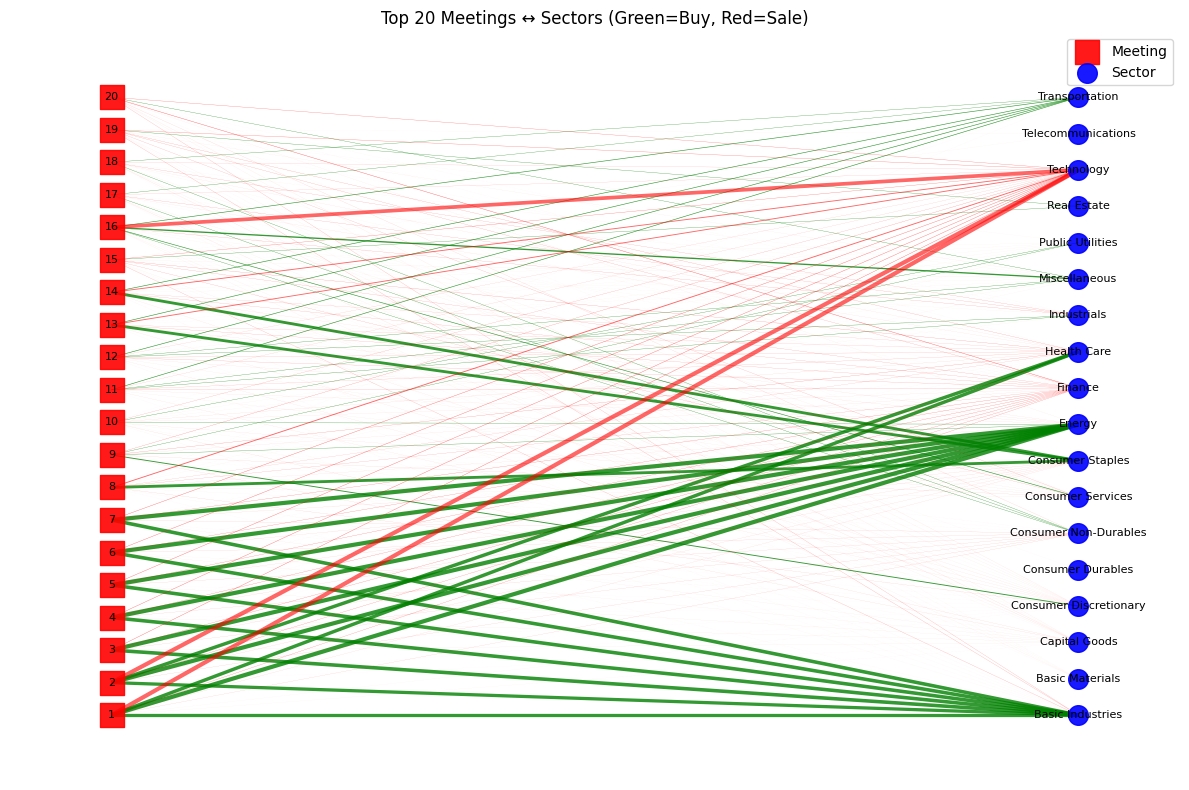

In [166]:
import matplotlib.pyplot as plt
import networkx as nx

# ――― Helper: Normalize raw transaction “type” into purchase/sale/exchange ―――
def normalize_action(raw):
    if not isinstance(raw, str):
        return "other"
    low = raw.lower()
    if "purchase" in low:
        return "purchase"
    elif "sale" in low:
        return "sale"
    else:
        return "other"

# ――― 1) Identify and sort all meeting nodes by degree (committee‐filtered) ―――
meeting_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "meeting"]
meeting_degs  = dict(G.degree(meeting_nodes))
sorted_meets  = sorted(meeting_degs.items(), key=lambda x: x[1], reverse=True)

# ――― 2) Pick the top N meetings to visualize ―――
TOP_N = 20
top_meet_nodes = [node for node, _ in sorted_meets[:TOP_N]]

# ――― 3) Print the “bills” (Meeting Titles) for those top meetings ―――
print(f"Top {TOP_N} meetings (bills) by committee‐filtered transaction count:\n")
for i, m in enumerate(top_meet_nodes, start=1):
    full_title = G.nodes[m]["title"]
    print(f"{i}. {full_title}")
print("\n")  # blank line before the plot

# ――― 4) For each top meeting, aggregate transaction volumes by sector and action ―――
# Structure: highlight_data[meeting][sector] = {"purchase": total_amt, "sale": total_amt}
highlight_data = {}

for m in top_meet_nodes:
    # Find all tx neighbors for this meeting
    tx_neighbors = [
        nbr for nbr in G.neighbors(m)
        if G.nodes[nbr]["type"] == "transaction"
    ]
    sector_action_sums = {}
    for tx_node in tx_neighbors:
        sector = G.nodes[tx_node].get("sector")
        amt    = G.nodes[tx_node].get("amount", 0)
        raw_action = G.nodes[tx_node].get("raw_type", "")
        action = normalize_action(raw_action)

        if sector is None or pd.isna(sector):
            continue

        if sector not in sector_action_sums:
            sector_action_sums[sector] = {"purchase": 0.0, "sale": 0.0}
        if action == "purchase":
            sector_action_sums[sector]["purchase"] += amt
        elif action == "sale":
            sector_action_sums[sector]["sale"] += amt

    highlight_data[m] = sector_action_sums

# ――― 5) Build a new graph H with meeting nodes + sector nodes ―――
H = nx.DiGraph()

# Add meeting nodes
for m in top_meet_nodes:
    H.add_node(m, type="meeting", title=G.nodes[m]["title"])

# Collect all sectors that appear for these meetings
all_sectors = set()
for data in highlight_data.values():
    all_sectors.update(data.keys())

# Add sector nodes
for sec in all_sectors:
    H.add_node(sec, type="sector")

# ――― 6) Add edges between meeting nodes and sector nodes, with attributes ―――
for m, sectors in highlight_data.items():
    for sec, actions in sectors.items():
        purchase_amt = actions.get("purchase", 0.0)
        sale_amt     = actions.get("sale", 0.0)

        if purchase_amt > 0:
            H.add_edge(m, sec, action="purchase", weight=purchase_amt)
        if sale_amt > 0:
            H.add_edge(m, sec, action="sale", weight=sale_amt)

# ――― 7) Create a bipartite layout for H ―――
pos = {}
# Place meetings at x=0, equally spaced by index
m_len = len(top_meet_nodes)
for i, m in enumerate(top_meet_nodes):
    pos[m] = (0.0, i / (m_len - 1 if m_len > 1 else 1.0))

# Place sectors at x=1, equally spaced by index
sectors_sorted = sorted(all_sectors)
s_len = len(sectors_sorted)
for i, sec in enumerate(sectors_sorted):
    pos[sec] = (1.0, i / (s_len - 1 if s_len > 1 else 1.0))

# ――― 8) Draw nodes and edges with Matplotlib ―――
plt.figure(figsize=(12, 8))

# 8a) Draw meeting nodes as red squares
nx.draw_networkx_nodes(
    H,
    pos,
    nodelist=top_meet_nodes,
    node_shape="s",
    node_color="red",
    node_size=300,
    alpha=0.9,
    label="Meeting"
)

# 8b) Draw sector nodes as blue circles
nx.draw_networkx_nodes(
    H,
    pos,
    nodelist=sectors_sorted,
    node_shape="o",
    node_color="blue",
    node_size=200,
    alpha=0.9,
    label="Sector"
)

# 8c) Draw purchase edges (m→sector) in green
purchase_edges = [(u, v) for u, v, d in H.edges(data=True) if d["action"] == "purchase"]
purchase_weights = [H[u][v]["weight"] for u, v in purchase_edges]
if purchase_edges:
    max_p = max(purchase_weights)
    widths_p = [3 * (w / max_p) for w in purchase_weights]
    nx.draw_networkx_edges(
        H,
        pos,
        edgelist=purchase_edges,
        edge_color="green",
        width=widths_p,
        alpha=0.8,
        arrows=False
    )

# 8d) Draw sale edges (m→sector) in red
sale_edges = [(u, v) for u, v, d in H.edges(data=True) if d["action"] == "sale"]
sale_weights = [H[u][v]["weight"] for u, v in sale_edges]
if sale_edges:
    max_s = max(sale_weights)
    widths_s = [3 * (w / max_s) for w in sale_weights]
    nx.draw_networkx_edges(
        H,
        pos,
        edgelist=sale_edges,
        edge_color="red",
        width=widths_s,
        alpha=0.6,
        arrows=False
    )

# 8e) Draw labels: numeric labels for meetings, full names for sectors
meeting_labels = {m: str(i) for i, m in enumerate(top_meet_nodes, start=1)}
sector_labels  = {sec: sec for sec in sectors_sorted}

nx.draw_networkx_labels(
    H,
    pos,
    labels={**meeting_labels, **sector_labels},
    font_size=8,
    font_color="black"
)

# 9) Legend and final touches
plt.title(f"Top {TOP_N} Meetings ↔ Sectors (Green=Buy, Red=Sale)")
plt.legend(scatterpoints=1)
plt.axis("off")
plt.tight_layout()
plt.show()


In [128]:
import pandas as pd
import networkx as nx

# ─── ASSUME YOU ALREADY HAVE THESE TWO DataFrames: ─────────────────────────
#   df         (columns: meeting_date, Meeting Title, …)
#   stock_tx   (columns: transaction_date, ticker, type, amount, member, …)
# ──────────────────────────────────────────────────────────────────────────

# 1.1) Convert to datetime if you haven’t already:
df['meeting_date']       = pd.to_datetime(df['meeting_date'])
stock_tx['transaction_date'] = pd.to_datetime(stock_tx['transaction_date'])

print(stock_tx["type"].unique())

stock_tx["type"] = stock_tx["type"].str.lower()

# 1.2) (OPTIONAL) If you only care about “bought” transactions, filter for type=="purchase" (and/or type.str.contains("purchase")):
buys = stock_tx[stock_tx['type'].str.contains("purchase", case=False, na=False)].copy()

# 1.3) Initialize a new Graph
G_ticker = nx.Graph()

# 1.4) Add meeting nodes
for m_idx, m_row in df.iterrows():
    meeting_node = f"meeting_{m_idx}"
    G_ticker.add_node(
        meeting_node,
        bipartite='meeting',
        title = m_row['Meeting Title'],
        date  = m_row['meeting_date']
    )

# 1.5) We will keep track of which ticker‐nodes we’ve already added,
#      to avoid re‐adding them inside the loop:
added_tickers = set()

# 1.6) For each meeting, find “buy” transactions within ±7 days, then group by ticker:
for m_idx, m_row in df.iterrows():
    meeting_node = f"meeting_{m_idx}"
    meeting_date = m_row['meeting_date']
    
    # define ±7‐day window:
    window_start = meeting_date - pd.Timedelta(days=30)
    window_end   = meeting_date + pd.Timedelta(days=30)
    
    # filter buys in that window:
    mask = (buys['transaction_date'] >= window_start) & (buys['transaction_date'] <= window_end)
    matching = buys.loc[mask, ['ticker', 'amount']]
    
    if matching.empty:
        continue
    
    # 1.6.1) Group by ticker: sum up “amount” for each ticker in that window
    grouped = matching.groupby('ticker')['amount'].sum().reset_index()
    #    If you’d rather just count occurrences, you could do:
    #    grouped = matching.groupby('ticker').size().reset_index(name='count')
    
    for _, row_t in grouped.iterrows():
        tk = row_t['ticker']
        total_amount = row_t['amount']
        ticker_node = f"ticker_{tk}"
        
        # 1.6.2) Add ticker node once (if not already added):
        if tk not in added_tickers:
            G_ticker.add_node(
                ticker_node,
                bipartite='ticker',
                symbol = tk
            )
            added_tickers.add(tk)
        
        # 1.6.3) Add an edge (meeting ⇆ ticker) with a “weight” = total_amount
        #       If you want “count” instead of “amount”, use that instead.
        G_ticker.add_edge(
            meeting_node,
            ticker_node,
            weight = total_amount
        )

# 1.7) Now G_ticker is a bipartite graph where:
#      - every “meeting_{i}” node connects to all “ticker_{SYMBOL}” nodes
#        whose total purchase‐amount (for that SYMBOL) in ±7 days of meeting_i > 0.
#      - edge attribute “weight” = sum of amounts for that ticker in that window.


['purchase' 'sale_partial' 'sale_full' 'exchange' 'sale' 'Sale (Full)'
 'Sale (Partial)' 'Purchase' 'Exchange']


In [129]:
# ─── 2.1) Identify all ticker‐nodes in G_ticker ─────────────────────────────
ticker_nodes = [n for n,d in G_ticker.nodes(data=True) if d.get('bipartite') == 'ticker']

# ─── 2.2) Raw degree (number of meetings connected to each ticker) ─────────
raw_deg = {tk: G_ticker.degree(tk) for tk in ticker_nodes}

# ─── 2.3) Weighted degree (sum of weights on edges to each ticker) ────────
# You can sum the “weight” attribute on every edge incident to that ticker:
weighted_deg = {}
for tk in ticker_nodes:
    total = 0
    for nbr in G_ticker[tk]:
        total += G_ticker[tk][nbr].get('weight', 0)
    weighted_deg[tk] = total

# ─── 2.4) Sort tickers by raw degree, descending ───────────────────────────
sorted_by_raw = sorted(raw_deg.items(), key=lambda x: x[1], reverse=True)

# ─── 2.5) Sort tickers by weighted degree, descending ──────────────────────
sorted_by_weight = sorted(weighted_deg.items(), key=lambda x: x[1], reverse=True)

# ─── 2.6) Display top‐10 by each metric ────────────────────────────────────
print("Top 10 tickers by # of distinct meetings (raw degree):")
for ticker_node, deg in sorted_by_raw[:10]:
    symbol = G_ticker.nodes[ticker_node]['symbol']
    print(f"  • {symbol:<8s}  → connected to {deg} meetings")

print("\nTop 10 tickers by total $ purchased (weighted degree):")
for ticker_node, total_amt in sorted_by_weight[:10]:
    symbol = G_ticker.nodes[ticker_node]['symbol']
    print(f"  • {symbol:<8s}  → ${total_amt:,.0f} total purchases")


Top 10 tickers by # of distinct meetings (raw degree):
  • KO        → connected to 407 meetings
  • WFC       → connected to 400 meetings
  • FDX       → connected to 377 meetings
  • T         → connected to 374 meetings
  • AMZN      → connected to 352 meetings
  • JNJ       → connected to 352 meetings
  • GOOG      → connected to 340 meetings
  • JPM       → connected to 340 meetings
  • DIS       → connected to 339 meetings
  • NVDA      → connected to 337 meetings

Top 10 tickers by total $ purchased (weighted degree):
  • MSFT      → $1,056,187,000 total purchases
  • ICE       → $947,656,000 total purchases
  • NVDA      → $150,376,000 total purchases
  • GOOGL     → $126,083,000 total purchases
  • CRM       → $123,825,000 total purchases
  • AMZN      → $111,473,000 total purchases
  • SPY       → $110,331,000 total purchases
  • NFLX      → $108,291,000 total purchases
  • PYPL      → $106,851,000 total purchases
  • ET        → $99,810,000 total purchases


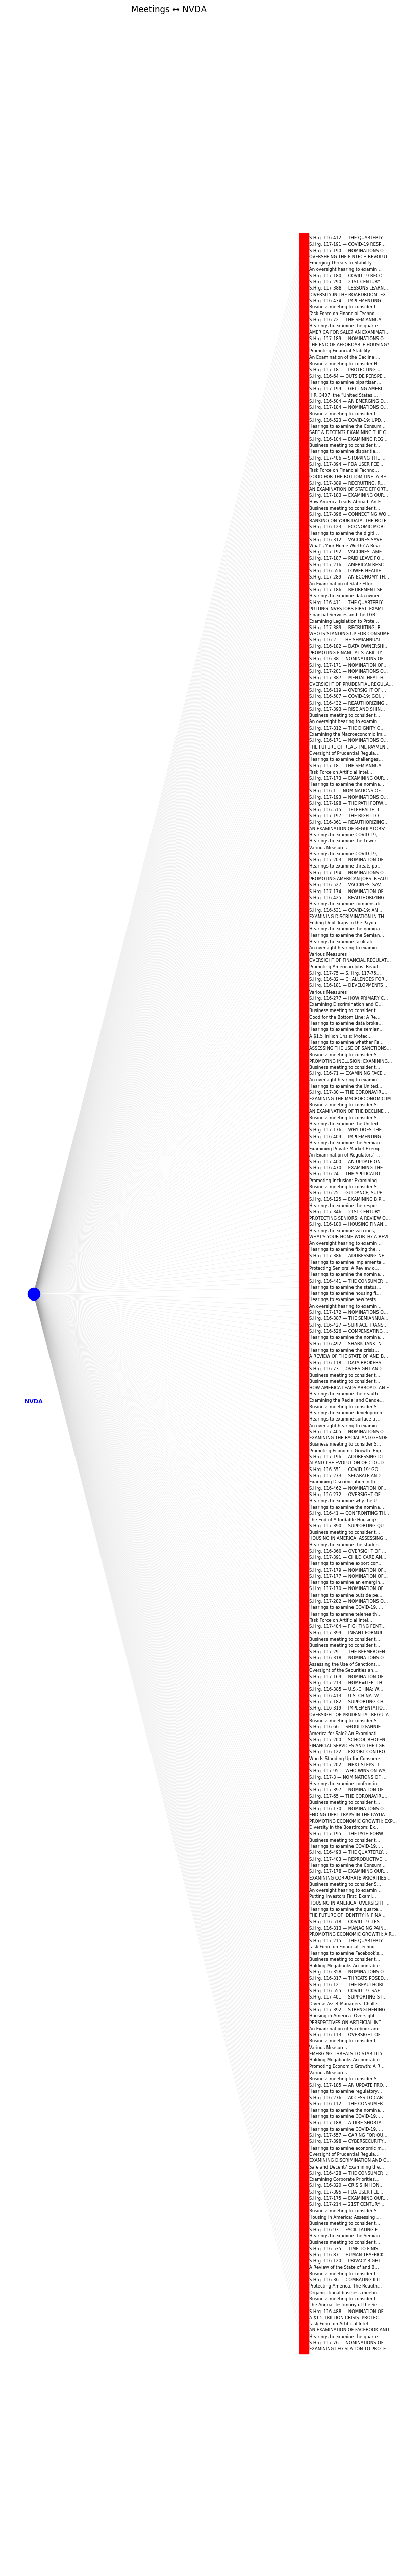

In [130]:
import matplotlib.pyplot as plt
import networkx as nx

# ────────────────────────────────────────────────────────────────────────────
# Assume G_ticker already exists, built exactly as before:
#   - meeting nodes named "meeting_{i}" (bipartite="meeting", title=…)
#   - ticker nodes named "ticker_{SYMBOL}" (bipartite="ticker", symbol=…)
#   - edges have weight=total_amount
# ────────────────────────────────────────────────────────────────────────────

stock = "NVDA"
target_node = f"ticker_{stock}"

# 1) Check that the node really exists
if target_node not in G_ticker:
    raise ValueError(f"Node {target_node!r} not found in G_ticker. "
                     f"Available tickers: {[n for n in G_ticker.nodes() if n.startswith('ticker_')]}")

# 2) Build the 1‐tickers + N‐meetings subgraph
neighbors = set(G_ticker.neighbors(target_node)) | {target_node}
subG = G_ticker.subgraph(neighbors).copy()

# 3) Identify all the meeting‐neighbors
meeting_neighbors = [
    n for n in subG.nodes()
    if subG.nodes[n].get("bipartite") == "meeting"
]

# 4) Create a simple “bipartite” layout for this subgraph:
pos_sub = {}

# 4a) Place the ticker itself at (0, 0.5)
pos_sub[target_node] = (0.0, 0.5)

# 4b) Spread all meetings at x=1, y ∈ [0,1]
n_meet = len(meeting_neighbors)
for i, m in enumerate(meeting_neighbors):
    if n_meet > 1:
        y = i / (n_meet - 1)
    else:
        y = 0.5
    pos_sub[m] = (1.0, y)

# 5) Dynamically size the figure so that if there are many meetings,
#    the plot gets taller to accommodate labels.
#    Each meeting “row” gets about 0.15 inches of vertical space (you can tweak).
height = max(4, n_meet * 0.15)
plt.figure(figsize=(8, height))

# 6) Draw edges in light gray
nx.draw_networkx_edges(
    subG,
    pos_sub,
    edge_color="#999999",
    alpha=0.2,
    width=0.5,
    arrows=False
)

# 7) Draw the ticker node (blue circle)
nx.draw_networkx_nodes(
    subG,
    pos_sub,
    nodelist=[target_node],
    node_color="blue",
    node_shape="o",
    node_size=300,
    label=stock
)

# 8) Draw the meeting nodes (red squares)
nx.draw_networkx_nodes(
    subG,
    pos_sub,
    nodelist=meeting_neighbors,
    node_color="red",
    node_shape="s",
    node_size=150
)

# 9) Now add labels **manually** so we can offset them and choose a tiny font.
#    9a) Ticker label sits just below the node at (0, 0.5)
tx_x, tx_y = pos_sub[target_node]
plt.text(
    tx_x, 
    tx_y - 0.05, 
    stock,
    ha="center", 
    va="top", 
    fontsize=8,
    color="blue",
    weight="bold"
)

#    9b) Each meeting label is drawn to the right of its red square.
for m in meeting_neighbors:
    title = subG.nodes[m]["title"]
    # Truncate long titles so they don't wrap endlessly
    if len(title) > 30:
        title = title[:30] + "…"
    x, y = pos_sub[m]
    plt.text(
        x + 0.02,    # small offset to the right
        y, 
        title,
        ha="left", 
        va="center", 
        fontsize=6,
        color="black"
    )

# 10) Tidy up
plt.axis("off")
plt.title(f"Meetings ↔ {stock}", fontsize=12)
plt.tight_layout()
plt.show()


Committee meetings where ≥ $1,000,000 was spent on NVDA:
  • S.Hrg. 116-488 — NOMINATION OF STEPHEN M. HAHN, M.D., TO SERVE AS COMMISSIONER OF FOOD AND DRUGS  (Amount = $1,157,000) | 2019-11-20 00:00:00
  • Business meeting to consider the nominations of Sharon Fast Gustafson, of Virginia, to be General Counsel,  and Charlotte A. Burrows, of the District of Columbia, to be a Member, both of the Equal Employment Opportunity Commission.  (Amount = $3,024,000) | 2019-07-30 00:00:00
  • Business meeting to consider the nominations of Gwen Graham, of Florida, to be Assistant Secretary for Legislation and Congressional Affairs, Department of Education, Rajesh D. Nayak, of Maryland, Taryn Mackenzie Williams, of the District of Columbia, and Douglas L. Parker, of West Virginia, each to be an Assistant Secretary of Labor, and Dawn Myers O'Connell, of the District of Columbia, to be Assistant Secretary for Preparedness and Response, and Miriam E. Delphin-Rittmon, of Connecticut, to be Assistant 

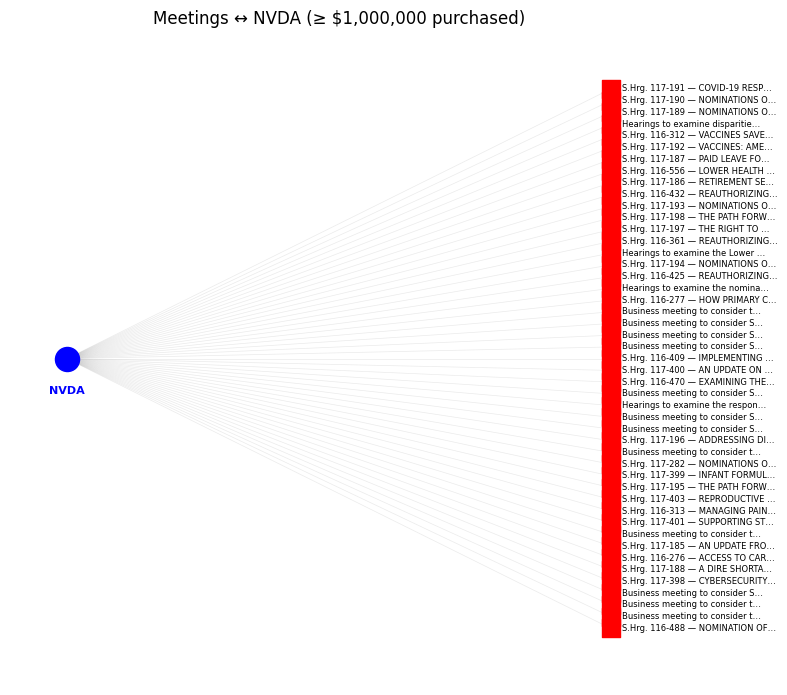

In [131]:
import matplotlib.pyplot as plt
import networkx as nx

stock = "NVDA"
target_node = f"ticker_{stock}"

# 1) Check that the node exists:
if target_node not in G_ticker:
    raise ValueError(f"Node {target_node!r} not in G_ticker.")

# 2) Choose a minimum‐amount threshold (in dollars).
min_amount = 1000000 # e.g. only show meetings where ≥ $10M was spent on ICE

# 3) Find all meeting neighbors, but only keep those whose edge‐weight >= min_amount
all_neighbors = set(G_ticker.neighbors(target_node))
filtered_meetings = []
for m in all_neighbors:
    w = G_ticker.edges[m, target_node].get("weight", 0)
    if w >= min_amount:
        filtered_meetings.append(m)

# 4) If no meetings pass the filter, warn and exit
if not filtered_meetings:
    print(f"No meetings found for {stock} with ≥ ${min_amount:,} in purchases.")
else:
    # ——— PRINT OUT THE FULL MEETING TITLES —————————————
    print(f"Committee meetings where ≥ ${min_amount:,} was spent on {stock}:")
    for m in filtered_meetings:
        full_title = G_ticker.nodes[m]["title"]
        amount_spent = G_ticker.edges[m, target_node]["weight"]
        date = G_ticker.nodes[m]["date"]
        print(f"  • {full_title}  (Amount = ${amount_spent:,}) | {date}")
    print("\n")  # extra blank line before the plot

    # 5) Build a subgraph containing only the ticker + these filtered meetings
    nodes_to_plot = filtered_meetings + [target_node]
    subG = G_ticker.subgraph(nodes_to_plot).copy()

    # 6) Create a simple bipartite layout:
    pos_sub = {}
    pos_sub[target_node] = (0.0, 0.5)  # place ticker at (0, 0.5)

    # spread meetings at x=1, y ∈ [0,1]
    n_meet = len(filtered_meetings)
    for i, m in enumerate(filtered_meetings):
        y = i / (n_meet - 1) if n_meet > 1 else 0.5
        pos_sub[m] = (1.0, y)

    # 7) Dynamically size figure height (0.15” per meeting)
    height = max(4, n_meet * 0.15)
    plt.figure(figsize=(8, height))

    # 8) Draw edges (light gray)
    nx.draw_networkx_edges(
        subG,
        pos_sub,
        edge_color="#999999",
        alpha=0.2,
        width=0.5,
        arrows=False
    )

    # 9) Draw the ticker node
    nx.draw_networkx_nodes(
        subG,
        pos_sub,
        nodelist=[target_node],
        node_color="blue",
        node_shape="o",
        node_size=300,
        label=stock
    )

    # 10) Draw filtered meeting nodes
    nx.draw_networkx_nodes(
        subG,
        pos_sub,
        nodelist=filtered_meetings,
        node_color="red",
        node_shape="s",
        node_size=150
    )

    # 11) Manually add labels (ticker + meetings)
    # 11a) Ticker’s label below its node
    tx_x, tx_y = pos_sub[target_node]
    plt.text(
        tx_x,
        tx_y - 0.05,
        stock,
        ha="center",
        va="top",
        fontsize=8,
        color="blue",
        weight="bold"
    )

    # 11b) Each meeting’s label to the right, truncated if too long
    for m in filtered_meetings:
        title = subG.nodes[m]["title"]
        if len(title) > 30:
            title = title[:30] + "…"
        x, y = pos_sub[m]
        plt.text(
            x + 0.02,
            y,
            title,
            ha="left",
            va="center",
            fontsize=6,
            color="black"
        )

    plt.axis("off")
    plt.title(f"Meetings ↔ {stock} (≥ ${min_amount:,} purchased)")
    plt.tight_layout()
    plt.show()
